Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [70]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [14]:
batch_size = 128
hidden_layer_size = 1024
L2_weight = 1e-3

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_hidden = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_layer_size]))
  biases_hidden = tf.Variable(tf.zeros([hidden_layer_size]))
  weights = tf.Variable(
    tf.truncated_normal([hidden_layer_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  hidden_layer_output = tf.nn.relu(tf.matmul(tf_train_dataset, weights_hidden)
                                   + biases_hidden)
  logits = tf.matmul(hidden_layer_output, weights) + biases
  l2_loss = L2_weight * (tf.nn.l2_loss(weights_hidden) + tf.nn.l2_loss(weights))
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + l2_loss
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_hidden)
                         + biases_hidden),weights) + biases)
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_hidden)
                         + biases_hidden), weights) + biases)

In [15]:
num_steps = 3001

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 757.184143
Minibatch accuracy: 13.3%
Validation accuracy: 32.6%
Minibatch loss at step 500: 201.144745
Minibatch accuracy: 80.5%
Validation accuracy: 78.7%
Minibatch loss at step 1000: 116.563080
Minibatch accuracy: 71.1%
Validation accuracy: 81.7%
Minibatch loss at step 1500: 69.655670
Minibatch accuracy: 76.6%
Validation accuracy: 83.2%
Minibatch loss at step 2000: 41.505993
Minibatch accuracy: 83.6%
Validation accuracy: 85.6%
Minibatch loss at step 2500: 25.015673
Minibatch accuracy: 94.5%
Validation accuracy: 86.2%
Minibatch loss at step 3000: 15.424565
Minibatch accuracy: 89.8%
Validation accuracy: 87.0%
Test accuracy: 92.8%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [27]:
batch_size = 40
hidden_layer_size = 1024
L2_weight = 1e-3

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_hidden = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_layer_size]))
  biases_hidden = tf.Variable(tf.zeros([hidden_layer_size]))
  weights = tf.Variable(
    tf.truncated_normal([hidden_layer_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  hidden_layer_output = tf.nn.relu(tf.matmul(tf_train_dataset, weights_hidden)
                                   + biases_hidden)
  logits = tf.matmul(hidden_layer_output, weights) + biases
  l2_loss = 0
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + l2_loss
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_hidden)
                         + biases_hidden),weights) + biases)
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_hidden)
                         + biases_hidden), weights) + biases)

In [28]:
num_steps = 3001

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0]/100 - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 370.034119
Minibatch accuracy: 10.0%
Validation accuracy: 25.5%
Minibatch loss at step 500: 0.829879
Minibatch accuracy: 97.5%
Validation accuracy: 77.6%
Minibatch loss at step 1000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 79.4%
Minibatch loss at step 1500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 79.4%
Minibatch loss at step 2000: 0.000002
Minibatch accuracy: 100.0%
Validation accuracy: 79.4%
Minibatch loss at step 2500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 79.4%
Minibatch loss at step 3000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 79.4%
Test accuracy: 87.2%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [31]:
batch_size = 128
hidden_layer_size = 1024
L2_weight = 1e-3

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  dropout_p = tf.placeholder(tf.float32)

  # Variables.
  weights_hidden = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_layer_size]))
  biases_hidden = tf.Variable(tf.zeros([hidden_layer_size]))
  weights = tf.Variable(
    tf.truncated_normal([hidden_layer_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  hidden_layer_output_without_dropout = tf.nn.relu(tf.matmul(tf_train_dataset, weights_hidden)
                                                   + biases_hidden)
  hidden_layer_output = tf.nn.dropout(hidden_layer_output_without_dropout, dropout_p)
  logits = tf.matmul(hidden_layer_output, weights) + biases
  l2_loss = L2_weight * (tf.nn.l2_loss(weights_hidden) + tf.nn.l2_loss(weights))
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + l2_loss
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_hidden)
                         + biases_hidden),weights) + biases)
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_hidden)
                         + biases_hidden), weights) + biases)

In [32]:
num_steps = 3001

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, dropout_p : 0.5}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 796.110596
Minibatch accuracy: 8.6%
Validation accuracy: 34.1%
Minibatch loss at step 500: 202.076553
Minibatch accuracy: 74.2%
Validation accuracy: 78.1%
Minibatch loss at step 1000: 120.055130
Minibatch accuracy: 64.1%
Validation accuracy: 80.5%
Minibatch loss at step 1500: 71.668633
Minibatch accuracy: 72.7%
Validation accuracy: 81.8%
Minibatch loss at step 2000: 41.826447
Minibatch accuracy: 74.2%
Validation accuracy: 83.7%
Minibatch loss at step 2500: 25.041143
Minibatch accuracy: 87.5%
Validation accuracy: 84.6%
Minibatch loss at step 3000: 15.443160
Minibatch accuracy: 84.4%
Validation accuracy: 85.5%
Test accuracy: 91.7%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [105]:
batch_size = 100
hidden_layer_1_size = 1024
hidden_layer_2_size = 100
# hidden_layer_3_size = 128
L2_weight = 1e-3

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  dropout_p = tf.placeholder(tf.float32)

  # Variables.
  weights_hidden_1 = tf.Variable(
     tf.truncated_normal([image_size * image_size, hidden_layer_1_size],
                          stddev=np.sqrt(2.0 / (image_size * image_size))))
  biases_hidden_1 = tf.Variable(tf.zeros([hidden_layer_1_size]))
  weights_hidden_2 = tf.Variable(
    tf.truncated_normal([ hidden_layer_1_size, hidden_layer_2_size]))
  biases_hidden_2 = tf.Variable(tf.zeros([hidden_layer_2_size]))
#   weights_hidden_3 = tf.Variable(
#     tf.truncated_normal([hidden_layer_2_size, hidden_layer_3_size]))
#   biases_hidden_3 = tf.Variable(tf.zeros([hidden_layer_3_size]))
  weights = tf.Variable(
    tf.truncated_normal([hidden_layer_2_size, num_labels],
                       stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases = tf.Variable(tf.zeros([num_labels]))
  global_step = tf.Variable(0)
  
  # Training computation.
  hidden_layer_1_output =
    tf.nn.relu(tf.matmul(tf_train_dataset, weights_hidden_1)
                                     + biases_hidden_1)
  hidden_layer_2_output = 
        tf.nn.relu(tf.matmul(hidden_layer_1_output, weights_hidden_2) 
                                     + biases_hidden_2)
  hidden_layer_3_output =  tf.nn.dropout(
        tf.nn.relu(tf.matmul(hidden_layer_2_output, weights_hidden_3)
                                     + biases_hidden_3), 0.5)
  logits = tf.matmul(hidden_layer_3_output, weights) + biases
  l2_loss = L2_weight * (tf.nn.l2_loss(weights_hidden_1) 
                         + tf.nn.l2_loss(weights_hidden_2) 
                         + tf.nn.l2_loss(weights_hidden_3)
                         + tf.nn.l2_loss(weights))

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer
  learning_rate = tf.train.exponential_decay(1e-4, global_step, 1500, .9, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, 0.2 * weights_hidden_1) + biases_hidden_1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, 0.2 * weights_hidden_2) + biases_hidden_2)
  lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights_hidden_3) + biases_hidden_3)
  valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights) + biases)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, 0.2 * weights_hidden_1) + biases_hidden_1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, 0.2 * weights_hidden_2) + biases_hidden_2)
  lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights_hidden_3) + biases_hidden_3)
  test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights) + biases)

Initialized
Minibatch loss at step 0: 194081.312500
Minibatch accuracy: 5.0%
Validation accuracy: 11.6%
Minibatch loss at step 500: 3920.210693
Minibatch accuracy: 26.0%
Validation accuracy: 55.9%
Minibatch loss at step 1000: 1281.498657
Minibatch accuracy: 36.0%
Validation accuracy: 52.8%
Minibatch loss at step 1500: 1283.926514
Minibatch accuracy: 24.0%
Validation accuracy: 42.3%
Minibatch loss at step 2000: 657.318970
Minibatch accuracy: 32.0%
Validation accuracy: 39.8%
Minibatch loss at step 2500: 581.036743
Minibatch accuracy: 24.0%
Validation accuracy: 36.8%
Minibatch loss at step 3000: 497.393127
Minibatch accuracy: 28.0%
Validation accuracy: 38.8%
Test accuracy: 42.8%


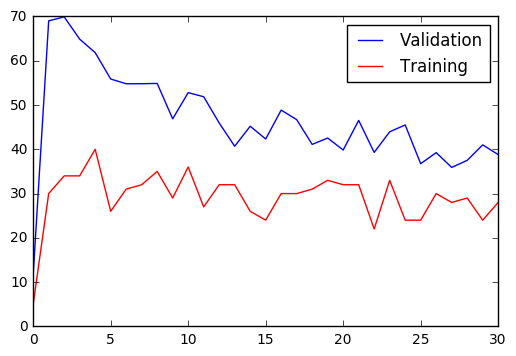

In [106]:
num_steps = 3001
validation_accuracy = []
training_accuracy = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, dropout_p : 0.5}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
        training_accuracy.append(accuracy(predictions, batch_labels))
        validation_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
    
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  n_steps = range(31)
  plt.figure()
  plt.plot(n_steps, validation_accuracy, 'b', label='Validation')
  plt.plot(n_steps, training_accuracy, 'r', label='Training')
  plt.legend(loc = 'upper right')
  plt.show()